In [ ]:
!pip install transformers spacy datasets scikit-learn matplotlib seaborn
!python -m spacy download en_core_web_sm

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 55.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from torchvision import transforms
from PIL import Image
import numpy as np
from tqdm import tqdm
import re
import spacy
from transformers import ViTFeatureExtractor, ViTModel, BertTokenizer, BertModel
import os
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the MuCR dataset
ds = load_dataset("Pinkygin/MuCR")
train_data = ds['train']

# Load spaCy for object detection in captions
nlp = spacy.load("en_core_web_sm")

# Define transforms for image preprocessing
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Initialize ViT feature extractor and model
vit_feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224").to(device)

# Initialize BERT tokenizer and model
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/577 [00:00<?, ?B/s]

(…)-00000-of-00001-6f8b5517c6be29cf.parquet:   0%|          | 0.00/380M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/400 [00:00<?, ? examples/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
class MuCRDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.label_map = {'person': 0, 'mixture': 1, 'animal': 2, 'plant': 3, 'character': 4}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image_0 = image_transform(item['image_0']).to(device)
        image_1 = image_transform(item['image_1']).to(device)
        caption_0 = item['caption_0']
        caption_1 = item['caption_1']
        label = torch.tensor(self.label_map[item['label']], dtype=torch.long).to(device)

        return image_0, image_1, caption_0, caption_1, label

class CausalModel(nn.Module):
    def __init__(self, text_embed_dim, image_embed_dim, hidden_dim, num_layers):
        super(CausalModel, self).__init__()
        self.text_gru = nn.GRU(text_embed_dim, hidden_dim, num_layers, batch_first=True)
        self.image_gru = nn.GRU(image_embed_dim, hidden_dim, num_layers, batch_first=True)
        self.fusion_gru = nn.GRU(hidden_dim * 3, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 5)  # 5 labels

    def forward(self, text_embed, image_0_embed, image_1_embed):
        _, text_hidden = self.text_gru(text_embed)
        _, image_0_hidden = self.image_gru(image_0_embed)
        _, image_1_hidden = self.image_gru(image_1_embed)

        fusion_input = torch.cat((text_hidden[-1], image_0_hidden[-1], image_1_hidden[-1]), dim=1)
        fusion_input = fusion_input.unsqueeze(1)  # Add sequence dimension

        _, fusion_hidden = self.fusion_gru(fusion_input)
        output = self.fc(fusion_hidden[-1])
        return output

NameError: name 'nn' is not defined

In [ ]:
import random
import spacy
import re

nlp = spacy.load("en_core_web_sm")

import random

def extract_objects_and_actions(caption):
    doc = nlp(caption)
    objects = [token.text for token in doc if token.pos_ in ['NOUN', 'PROPN']]
    actions = [token.text for token in doc if token.pos_ == 'VERB']
    return objects, actions

def replace_objects_with_placeholders(caption, objects):
    for i, obj in enumerate(objects):
        caption = re.sub(r'\b' + re.escape(obj) + r'\b', f'[OBJ{i}]', caption, count=1)
    return caption

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [ ]:
def generate_caption(model, image_0, image_1, caption_0, caption_1):
    with torch.no_grad():
        image_0_embed = vit_model(image_0).last_hidden_state
        image_1_embed = vit_model(image_1).last_hidden_state
        text_inputs = bert_tokenizer(caption_0, return_tensors="pt", padding=True, truncation=True).to(device)
        text_embed = bert_model(**text_inputs).last_hidden_state

        output = model(text_embed, image_0_embed, image_1_embed)
        predicted_label = torch.argmax(output, dim=1).item()

        objects_0, actions_0 = extract_objects_and_actions(caption_0)
        objects_1, actions_1 = extract_objects_and_actions(caption_1)

        all_objects = list(set(objects_0 + objects_1))
        all_actions = list(set(actions_0 + actions_1))

        # Generate caption based on predicted label and extracted information
        label_map = {0: 'person', 1: 'mixture', 2: 'animal', 3: 'plant', 4: 'character'}
        predicted_label_text = label_map[predicted_label]

        templates = {
            'person': [
                "A [OBJ] is seen [ACTION] in the image.",
                "The image shows a [OBJ] [ACTION].",
                "We can observe a [OBJ] [ACTION] in this scene."
            ],
            'mixture': [
                "The image displays a combination of [OBJ1] and [OBJ2].",
                "A mix of [OBJ1] and [OBJ2] can be seen in the picture.",
                "The scene contains both [OBJ1] and [OBJ2]."
            ],
            'animal': [
                "A [OBJ] is observed [ACTION] in its environment.",
                "The image shows a [OBJ] [ACTION].",
                "We can see a [OBJ] [ACTION] in this picture."
            ],
            'plant': [
                "The image displays a [OBJ] in a natural setting.",
                "A [OBJ] can be seen [ACTION] in the picture.",
                "The scene shows a [OBJ] in its environment."
            ],
            'character': [
                "A character resembling [OBJ] is depicted [ACTION] in the image.",
                "The image shows a [OBJ]-like character [ACTION].",
                "We can see a character that looks like a [OBJ] [ACTION]."
            ]
        }

        template = random.choice(templates[predicted_label_text])

        # Replace placeholders with actual objects and actions
        generated_caption = template.replace("[OBJ]", random.choice(all_objects) if all_objects else "subject")
        generated_caption = generated_caption.replace("[OBJ1]", all_objects[0] if len(all_objects) > 0 else "subject")
        generated_caption = generated_caption.replace("[OBJ2]", all_objects[1] if len(all_objects) > 1 else "object")
        generated_caption = generated_caption.replace("[ACTION]", random.choice(all_actions) if all_actions else "doing something")

    return generated_caption


In [ ]:
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from torch.utils.data import DataLoader

# Prepare data for stratified cross-validation
labels = [item['label'] for item in train_data]

# Define the number of folds for cross-validation
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# Lists to store the data loaders for each fold
train_loaders = []
val_loaders = []
test_loaders = []

# Perform cross-validation splits
for fold, (train_temp_idx, test_idx) in enumerate(skf.split(range(len(train_data)), labels)):
    # Get labels for temporary training set
    train_temp_labels = [labels[i] for i in train_temp_idx]

    # Split temporary training data into training and validation
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_idx, val_idx = next(sss.split(train_temp_idx, train_temp_labels))

    # Create the datasets for this fold
    train_dataset = [train_data[int(i)] for i in train_idx]
    val_dataset = [train_data[int(i)] for i in val_idx]
    test_dataset = [train_data[int(i)] for i in test_idx]

    # Create data loaders for this fold
    train_loaders.append(DataLoader(MuCRDataset(train_dataset), batch_size=32, shuffle=True))
    val_loaders.append(DataLoader(MuCRDataset(val_dataset), batch_size=32, shuffle=False))
    test_loaders.append(DataLoader(MuCRDataset(test_dataset), batch_size=32, shuffle=False))

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np

def train_model_cv(model, train_loaders, val_loaders, criterion, optimizer, num_epochs, patience=5):
    all_fold_models = []
    all_fold_metrics = []

    for fold in range(len(train_loaders)):
        print(f"\nTraining Fold {fold+1}/{len(train_loaders)}")

        # Reinitialize model and optimizer for this fold
        model = CausalModel(text_embed_dim=768, image_embed_dim=768, hidden_dim=256, num_layers=2).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

        best_val_loss = float('inf')
        epochs_no_improve = 0
        train_losses = []
        val_losses = []
        learning_rates = []

        # Learning rate scheduler
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
        l2_lambda = 0.001

        for epoch in range(num_epochs):
            model.train()
            train_loss = 0.0
            for image_0, image_1, caption_0, caption_1, labels in tqdm(train_loaders[fold],
                                                                      desc=f"Fold {fold+1}, Epoch {epoch+1}/{num_epochs}"):
                optimizer.zero_grad()

                image_0_embed = vit_model(image_0).last_hidden_state
                image_1_embed = vit_model(image_1).last_hidden_state
                text_inputs = bert_tokenizer(list(caption_0), return_tensors="pt", padding=True, truncation=True).to(device)
                text_embed = bert_model(**text_inputs).last_hidden_state

                outputs = model(text_embed, image_0_embed, image_1_embed)
                loss = criterion(outputs, labels)

                # L2 regularization
                l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
                loss = loss + l2_lambda * l2_norm

                loss.backward()

                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                optimizer.step()
                train_loss += loss.item()

            train_loss /= len(train_loaders[fold])
            train_losses.append(train_loss)

            # Validation
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for image_0, image_1, caption_0, caption_1, labels in val_loaders[fold]:
                    image_0_embed = vit_model(image_0).last_hidden_state
                    image_1_embed = vit_model(image_1).last_hidden_state
                    text_inputs = bert_tokenizer(list(caption_0), return_tensors="pt", padding=True, truncation=True).to(device)
                    text_embed = bert_model(**text_inputs).last_hidden_state

                    outputs = model(text_embed, image_0_embed, image_1_embed)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

            val_loss /= len(val_loaders[fold])
            val_losses.append(val_loss)

            print(f"Fold {fold+1}, Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

            # Learning rate scheduling
            scheduler.step(val_loss)
            learning_rates.append(optimizer.param_groups[0]['lr'])

            # Check for improvement
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), f'best_model_fold_{fold}.pth')
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1

            # Automatic adjustment for overfitting and underfitting
            if epoch > 5:
                if val_loss > 1.1 * min(val_losses):  # Potential overfitting
                    l2_lambda *= 1.2  # Increase regularization
                elif train_loss > 0.95 * train_losses[0]:  # Potential underfitting
                    l2_lambda /= 1.2  # Decrease regularization

            # Early stopping
            if epochs_no_improve == patience:
                print(f"Early stopping triggered for fold {fold+1}. No improvement for {patience} epochs.")
                break

        # Load the best model for this fold
        model.load_state_dict(torch.load(f'best_model_fold_{fold}.pth'))
        all_fold_models.append(model)
        all_fold_metrics.append({
            'train_losses': train_losses,
            'val_losses': val_losses,
            'learning_rates': learning_rates
        })

    # Find the best performing fold
    best_fold = np.argmin([metrics['val_losses'][-1] for metrics in all_fold_metrics])

    print(f"\nBest performing fold: {best_fold + 1}")
    print(f"Best validation loss: {all_fold_metrics[best_fold]['val_losses'][-1]:.4f}")

    return (all_fold_models[best_fold],
            all_fold_metrics[best_fold]['train_losses'],
            all_fold_metrics[best_fold]['val_losses'],
            all_fold_metrics[best_fold]['learning_rates'])

# Initialize the model
model = CausalModel(text_embed_dim=768, image_embed_dim=768, hidden_dim=256, num_layers=2).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)


# Train the model with cross-validation
num_epochs = 50
trained_model, train_losses, val_losses, learning_rates = train_model_cv(model, train_loaders, val_loaders, criterion, optimizer, num_epochs)


Training Fold 1/5


Fold 1, Epoch 1/50: 100%|██████████| 8/8 [00:20<00:00,  2.57s/it]


Fold 1, Epoch 1/50, Train Loss: 5.2492, Val Loss: 0.7044


Fold 1, Epoch 2/50: 100%|██████████| 8/8 [00:17<00:00,  2.22s/it]


Fold 1, Epoch 2/50, Train Loss: 3.5310, Val Loss: 0.5550


Fold 1, Epoch 3/50: 100%|██████████| 8/8 [00:18<00:00,  2.31s/it]


Fold 1, Epoch 3/50, Train Loss: 2.5833, Val Loss: 0.2922


Fold 1, Epoch 4/50: 100%|██████████| 8/8 [00:18<00:00,  2.36s/it]


Fold 1, Epoch 4/50, Train Loss: 1.9197, Val Loss: 0.3820


Fold 1, Epoch 5/50: 100%|██████████| 8/8 [00:18<00:00,  2.31s/it]


Fold 1, Epoch 5/50, Train Loss: 1.4623, Val Loss: 0.2520


Fold 1, Epoch 6/50: 100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


Fold 1, Epoch 6/50, Train Loss: 1.1816, Val Loss: 0.5324


Fold 1, Epoch 7/50: 100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


Fold 1, Epoch 7/50, Train Loss: 0.9701, Val Loss: 0.4756


Fold 1, Epoch 8/50: 100%|██████████| 8/8 [00:18<00:00,  2.30s/it]


Fold 1, Epoch 8/50, Train Loss: 0.9784, Val Loss: 0.3724


Fold 1, Epoch 9/50: 100%|██████████| 8/8 [00:18<00:00,  2.31s/it]


Fold 1, Epoch 9/50, Train Loss: 0.9789, Val Loss: 0.3307


Fold 1, Epoch 10/50: 100%|██████████| 8/8 [00:18<00:00,  2.32s/it]
<ipython-input-7-649a3c4b689c>:102: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(to

Fold 1, Epoch 10/50, Train Loss: 1.0222, Val Loss: 0.3395
Early stopping triggered for fold 1. No improvement for 5 epochs.

Training Fold 2/5


Fold 2, Epoch 1/50: 100%|██████████| 8/8 [00:18<00:00,  2.29s/it]


Fold 2, Epoch 1/50, Train Loss: 5.3420, Val Loss: 0.7216


Fold 2, Epoch 2/50: 100%|██████████| 8/8 [00:18<00:00,  2.32s/it]


Fold 2, Epoch 2/50, Train Loss: 3.5790, Val Loss: 0.4086


Fold 2, Epoch 3/50: 100%|██████████| 8/8 [00:18<00:00,  2.31s/it]


Fold 2, Epoch 3/50, Train Loss: 2.5410, Val Loss: 0.3530


Fold 2, Epoch 4/50: 100%|██████████| 8/8 [00:18<00:00,  2.34s/it]


Fold 2, Epoch 4/50, Train Loss: 1.8348, Val Loss: 0.9103


Fold 2, Epoch 5/50: 100%|██████████| 8/8 [00:18<00:00,  2.30s/it]


Fold 2, Epoch 5/50, Train Loss: 1.4355, Val Loss: 0.6284


Fold 2, Epoch 6/50: 100%|██████████| 8/8 [00:18<00:00,  2.32s/it]


Fold 2, Epoch 6/50, Train Loss: 1.1453, Val Loss: 0.4936


Fold 2, Epoch 7/50: 100%|██████████| 8/8 [00:18<00:00,  2.32s/it]


Fold 2, Epoch 7/50, Train Loss: 0.9226, Val Loss: 0.9108


Fold 2, Epoch 8/50: 100%|██████████| 8/8 [00:18<00:00,  2.31s/it]


Fold 2, Epoch 8/50, Train Loss: 0.9566, Val Loss: 0.9417
Early stopping triggered for fold 2. No improvement for 5 epochs.

Training Fold 3/5


Fold 3, Epoch 1/50: 100%|██████████| 8/8 [00:18<00:00,  2.31s/it]


Fold 3, Epoch 1/50, Train Loss: 5.3392, Val Loss: 0.7993


Fold 3, Epoch 2/50: 100%|██████████| 8/8 [00:18<00:00,  2.32s/it]


Fold 3, Epoch 2/50, Train Loss: 3.5943, Val Loss: 0.4459


Fold 3, Epoch 3/50: 100%|██████████| 8/8 [00:18<00:00,  2.31s/it]


Fold 3, Epoch 3/50, Train Loss: 2.5693, Val Loss: 0.3727


Fold 3, Epoch 4/50: 100%|██████████| 8/8 [00:18<00:00,  2.29s/it]


Fold 3, Epoch 4/50, Train Loss: 1.9207, Val Loss: 0.3758


Fold 3, Epoch 5/50: 100%|██████████| 8/8 [00:18<00:00,  2.31s/it]


Fold 3, Epoch 5/50, Train Loss: 1.4984, Val Loss: 0.3253


Fold 3, Epoch 6/50: 100%|██████████| 8/8 [00:18<00:00,  2.29s/it]


Fold 3, Epoch 6/50, Train Loss: 1.2041, Val Loss: 0.4036


Fold 3, Epoch 7/50: 100%|██████████| 8/8 [00:18<00:00,  2.32s/it]


Fold 3, Epoch 7/50, Train Loss: 0.9782, Val Loss: 0.4615


Fold 3, Epoch 8/50: 100%|██████████| 8/8 [00:18<00:00,  2.30s/it]


Fold 3, Epoch 8/50, Train Loss: 0.9833, Val Loss: 0.4302


Fold 3, Epoch 9/50: 100%|██████████| 8/8 [00:18<00:00,  2.33s/it]


Fold 3, Epoch 9/50, Train Loss: 0.9949, Val Loss: 0.4027


Fold 3, Epoch 10/50: 100%|██████████| 8/8 [00:18<00:00,  2.31s/it]


Fold 3, Epoch 10/50, Train Loss: 1.0369, Val Loss: 0.3850
Early stopping triggered for fold 3. No improvement for 5 epochs.

Training Fold 4/5


Fold 4, Epoch 1/50: 100%|██████████| 8/8 [00:18<00:00,  2.33s/it]


Fold 4, Epoch 1/50, Train Loss: 5.2574, Val Loss: 0.8008


Fold 4, Epoch 2/50: 100%|██████████| 8/8 [00:18<00:00,  2.30s/it]


Fold 4, Epoch 2/50, Train Loss: 3.5354, Val Loss: 0.5532


Fold 4, Epoch 3/50: 100%|██████████| 8/8 [00:18<00:00,  2.32s/it]


Fold 4, Epoch 3/50, Train Loss: 2.5733, Val Loss: 0.4832


Fold 4, Epoch 4/50: 100%|██████████| 8/8 [00:18<00:00,  2.31s/it]


Fold 4, Epoch 4/50, Train Loss: 1.9207, Val Loss: 0.6130


Fold 4, Epoch 5/50: 100%|██████████| 8/8 [00:18<00:00,  2.31s/it]


Fold 4, Epoch 5/50, Train Loss: 1.4742, Val Loss: 0.5037


Fold 4, Epoch 6/50: 100%|██████████| 8/8 [00:18<00:00,  2.33s/it]


Fold 4, Epoch 6/50, Train Loss: 1.1540, Val Loss: 0.5121


Fold 4, Epoch 7/50: 100%|██████████| 8/8 [00:18<00:00,  2.31s/it]


Fold 4, Epoch 7/50, Train Loss: 0.9381, Val Loss: 0.5164


Fold 4, Epoch 8/50: 100%|██████████| 8/8 [00:18<00:00,  2.33s/it]


Fold 4, Epoch 8/50, Train Loss: 0.8180, Val Loss: 0.5146
Early stopping triggered for fold 4. No improvement for 5 epochs.

Training Fold 5/5


Fold 5, Epoch 1/50: 100%|██████████| 8/8 [00:18<00:00,  2.31s/it]


Fold 5, Epoch 1/50, Train Loss: 5.2881, Val Loss: 0.7853


Fold 5, Epoch 2/50: 100%|██████████| 8/8 [00:18<00:00,  2.32s/it]


Fold 5, Epoch 2/50, Train Loss: 3.5636, Val Loss: 0.4917


Fold 5, Epoch 3/50: 100%|██████████| 8/8 [00:18<00:00,  2.31s/it]


Fold 5, Epoch 3/50, Train Loss: 2.5322, Val Loss: 0.5007


Fold 5, Epoch 4/50: 100%|██████████| 8/8 [00:18<00:00,  2.33s/it]


Fold 5, Epoch 4/50, Train Loss: 1.8584, Val Loss: 0.4109


Fold 5, Epoch 5/50: 100%|██████████| 8/8 [00:18<00:00,  2.31s/it]


Fold 5, Epoch 5/50, Train Loss: 1.4322, Val Loss: 0.4289


Fold 5, Epoch 6/50: 100%|██████████| 8/8 [00:18<00:00,  2.32s/it]


Fold 5, Epoch 6/50, Train Loss: 1.1259, Val Loss: 0.4964


Fold 5, Epoch 7/50: 100%|██████████| 8/8 [00:18<00:00,  2.30s/it]


Fold 5, Epoch 7/50, Train Loss: 0.9146, Val Loss: 0.5664


Fold 5, Epoch 8/50: 100%|██████████| 8/8 [00:18<00:00,  2.32s/it]


Fold 5, Epoch 8/50, Train Loss: 0.9113, Val Loss: 0.5902


Fold 5, Epoch 9/50: 100%|██████████| 8/8 [00:18<00:00,  2.32s/it]


Fold 5, Epoch 9/50, Train Loss: 0.9686, Val Loss: 0.4806
Early stopping triggered for fold 5. No improvement for 5 epochs.

Best performing fold: 1
Best validation loss: 0.3395


Enter the best performing fold number (1-5): 1

MODEL PERFORMANCE METRICS FOR FOLD 1

Classification Metrics:
Accuracy:       0.9375
Precision:      0.9418
Recall:         0.9375
F1-score:       0.9317
ROC AUC:        0.9928
Cohen's Kappa:  0.9070



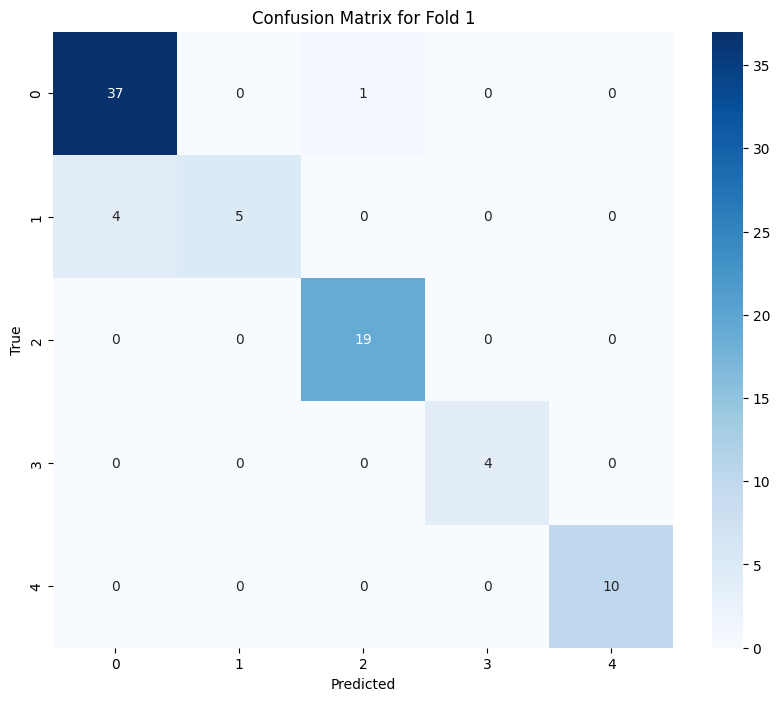


TRAINING VISUALIZATIONS FOR FOLD 1



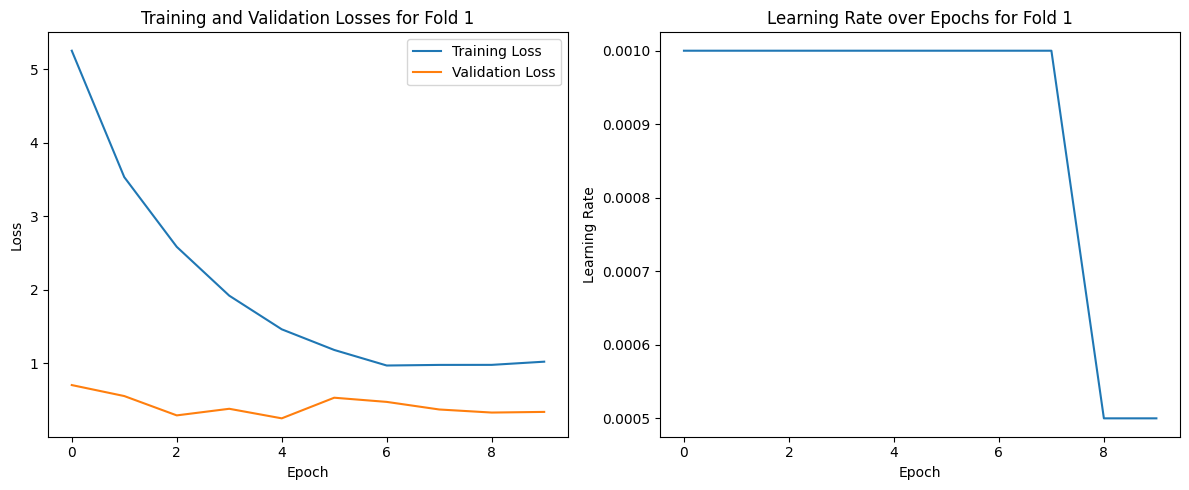

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score, cohen_kappa_score
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_and_print_metrics(model, test_loaders, vit_model, bert_model, bert_tokenizer, device, train_losses, val_losses, learning_rates):
    # Get the best fold number from user input
    best_fold = int(input("Enter the best performing fold number (1-5): ")) - 1

    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    # Use test loader from the best fold
    test_loader = test_loaders[best_fold]

    with torch.no_grad():
        for image_0, image_1, caption_0, caption_1, labels in test_loader:
            # Get embeddings for images and text
            image_0_embed = vit_model(image_0).last_hidden_state
            image_1_embed = vit_model(image_1).last_hidden_state
            text_inputs = bert_tokenizer(list(caption_0), return_tensors="pt", padding=True, truncation=True).to(device)
            text_embed = bert_model(**text_inputs).last_hidden_state

            # Get model outputs
            outputs = model(text_embed, image_0_embed, image_1_embed)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            # Append predictions and labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    print("\n" + "="*50)
    print(f"MODEL PERFORMANCE METRICS FOR FOLD {best_fold + 1}")
    print("="*50 + "\n")

    # 1. Classification Metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

    # Handle the case for ROC AUC
    roc_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='weighted') if len(set(all_labels)) > 2 else roc_auc_score(all_labels, all_probs[:, 1])

    kappa = cohen_kappa_score(all_labels, all_preds)

    print("Classification Metrics:")
    print(f"{'Accuracy:':<15} {accuracy:.4f}")
    print(f"{'Precision:':<15} {precision:.4f}")
    print(f"{'Recall:':<15} {recall:.4f}")
    print(f"{'F1-score:':<15} {f1:.4f}")
    print(f"{'ROC AUC:':<15} {roc_auc:.4f}")
    print("{:<15} {:.4f}\n".format("Cohen's Kappa:", kappa))

    # 2. Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for Fold {best_fold + 1}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    print("\n" + "="*50)
    print(f"TRAINING VISUALIZATIONS FOR FOLD {best_fold + 1}")
    print("="*50 + "\n")

    # 3. Training and Validation Loss curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'Training and Validation Losses for Fold {best_fold + 1}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # 4. Learning Rate changes
    plt.subplot(1, 2, 2)
    plt.plot(learning_rates)
    plt.title(f'Learning Rate over Epochs for Fold {best_fold + 1}')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.tight_layout()
    plt.show()

# Call the function with all loaders
calculate_and_print_metrics(
    trained_model,
    test_loaders,  # Pass all test loaders
    vit_model,
    bert_model,
    bert_tokenizer,
    device,
    train_losses,
    val_losses,
    learning_rates
)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from tqdm import tqdm

def get_sentence_embedding(sentence):
    inputs = bert_tokenizer(sentence, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()

def evaluate_captions(model, test_loaders):
    # Get the best fold number from user input
    best_fold = int(input("Enter the best performing fold number (1-5): ")) - 1

    # Use test loader from the best fold
    test_loader = test_loaders[best_fold]

    model.eval()
    generated_captions = []
    actual_captions = []
    similarity_scores = []

    print(f"\nEvaluating captions for Fold {best_fold + 1}")
    print("="*50)

    with torch.no_grad():
        for image_0_batch, image_1_batch, caption_0_batch, caption_1_batch, _ in tqdm(test_loader,
                                                                                     desc=f"Generating captions for Fold {best_fold + 1}"):
            for j in range(len(image_0_batch)):
                image_0 = image_0_batch[j].unsqueeze(0)
                image_1 = image_1_batch[j].unsqueeze(0)
                caption_0 = caption_0_batch[j]
                caption_1 = caption_1_batch[j]

                generated_caption = generate_caption(model, image_0, image_1, caption_0, caption_1)
                generated_captions.append(generated_caption)
                actual_captions.append(caption_1)

                # Calculate similarity score
                gen_embedding = get_sentence_embedding(generated_caption)
                actual_embedding = get_sentence_embedding(caption_1)
                similarity = cosine_similarity(gen_embedding.reshape(1, -1), actual_embedding.reshape(1, -1))[0][0]
                similarity_scores.append(similarity)

    average_similarity = np.mean(similarity_scores)

    print("\nCaption Generation Results:")
    print("="*50)
    print(f"Fold {best_fold + 1} Results:")
    print(f"Average similarity score: {average_similarity:.4f}")
    print(f"Total captions evaluated: {len(generated_captions)}")

    return generated_captions, actual_captions, similarity_scores

# Call the evaluation function
generated_captions, actual_captions, similarity_scores = evaluate_captions(trained_model, test_loaders)

Enter the best performing fold number (1-5): 1

Evaluating captions for Fold 1


Generating captions for Fold 1: 100%|██████████| 3/3 [00:06<00:00,  2.27s/it]


Caption Generation Results:
Fold 1 Results:
Average similarity score: 0.6211
Total captions evaluated: 80


In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from transformers import CLIPModel, CLIPProcessor, BertModel, BertTokenizer, ViTModel, ViTFeatureExtractor
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from tqdm import tqdm

class PretrainedModelWrapper(nn.Module):
    def __init__(self, image_model, text_model, processor=None):
        super().__init__()
        self.image_model = image_model
        self.text_model = text_model
        self.processor = processor

        # Determine the feature size for the image model
        if hasattr(image_model, 'config'):
            self.image_feature_size = image_model.config.hidden_size
        elif isinstance(image_model, models.ResNet):
            self.image_feature_size = image_model.fc.in_features
        elif isinstance(image_model, models.EfficientNet):
            self.image_feature_size = image_model.classifier[1].in_features
        else:
            raise ValueError("Unsupported image model type")

        self.text_feature_size = text_model.config.hidden_size

    def forward(self, image_0, image_1, input_ids, attention_mask):
        if hasattr(self.image_model, 'config'):
            img_0_features = self.image_model(image_0).last_hidden_state.mean(dim=1)
            img_1_features = self.image_model(image_1).last_hidden_state.mean(dim=1)
        else:
            img_0_features = self.image_model(image_0)
            img_1_features = self.image_model(image_1)

        text_features = self.text_model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state.mean(dim=1)

        combined_features = torch.cat([img_0_features, img_1_features, text_features], dim=1)

        # Initialize the classifier if it hasn't been initialized yet
        if not hasattr(self, 'classifier'):
            input_size = combined_features.shape[1]
            self.classifier = nn.Linear(input_size, 5).to(combined_features.device)

        return self.classifier(combined_features)

def evaluate_model(model, test_loaders, device):
    # Get the best fold number from user input
    best_fold = int(input(f"Enter the best performing fold number (1-5) for {model.__class__.__name__}: ")) - 1

    # Use test loader from the best fold
    test_loader = test_loaders[best_fold]

    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    print(f"\nEvaluating model on Fold {best_fold + 1}")
    print("="*50)

    with torch.no_grad():
        for image_0, image_1, caption_0, caption_1, labels in tqdm(test_loader, desc=f"Evaluating on Fold {best_fold + 1}"):
            image_0, image_1 = image_0.to(device), image_1.to(device)
            labels = labels.to(device)

            if isinstance(model, PretrainedModelWrapper):
                if model.processor:
                    # For CLIP
                    text_inputs = model.processor(text=caption_0, return_tensors="pt", padding=True, truncation=True)
                else:
                    # For BERT
                    text_inputs = BertTokenizer.from_pretrained("bert-base-uncased")(caption_0, padding=True, truncation=True, return_tensors="pt")
                input_ids = text_inputs['input_ids'].to(device)
                attention_mask = text_inputs['attention_mask'].to(device)
                outputs = model(image_0, image_1, input_ids, attention_mask)
            else:
                # Your GRU model forward pass
                image_0_embed = vit_model(image_0).last_hidden_state
                image_1_embed = vit_model(image_1).last_hidden_state
                text_inputs = bert_tokenizer(list(caption_0), return_tensors="pt", padding=True, truncation=True).to(device)
                text_embed = bert_model(**text_inputs).last_hidden_state
                outputs = model(text_embed, image_0_embed, image_1_embed)

            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    roc_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='weighted')

    return accuracy, precision, recall, f1, roc_auc

# Initialize models
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

models_to_compare = {
    "Your GRU Model": trained_model,
    "CLIP": PretrainedModelWrapper(clip_model.vision_model,
                                   clip_model.text_model,
                                   processor=clip_processor),
    "ViT + BERT": PretrainedModelWrapper(ViTModel.from_pretrained("google/vit-base-patch16-224"),
                                         BertModel.from_pretrained("bert-base-uncased")),
    "ResNet + BERT": PretrainedModelWrapper(models.resnet50(pretrained=True),
                                            BertModel.from_pretrained("bert-base-uncased")),
    "EfficientNet + BERT": PretrainedModelWrapper(models.efficientnet_b0(pretrained=True),
                                                  BertModel.from_pretrained("bert-base-uncased")),
}

# Evaluate all models
results = {}
for name, model in models_to_compare.items():
    print(f"\nEvaluating {name}...")
    model = model.to(device)
    accuracy, precision, recall, f1, roc_auc = evaluate_model(model, test_loaders, device)
    results[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1,
        "ROC AUC": roc_auc
    }

# Print results
print("\n" + "="*100)
print("MODEL COMPARISON RESULTS")
print("="*100)
print(f"{'Model':<20} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-score':<10} {'ROC AUC':<10}")
print("-"*100)
for name, metrics in results.items():
    print(f"{name:<20} {metrics['Accuracy']:.4f}     {metrics['Precision']:.4f}     {metrics['Recall']:.4f}     {metrics['F1-score']:.4f}     {metrics['ROC AUC']:.4f}")
print("="*100)

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments


Evaluating Your GRU Model...
Enter the best performing fold number (1-5) for CausalModel: 1

Evaluating model on Fold 1


Evaluating on Fold 1: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]



Evaluating CLIP...
Enter the best performing fold number (1-5) for PretrainedModelWrapper: 1

Evaluating model on Fold 1


Evaluating on Fold 1: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Evaluating ViT + BERT...
Enter the best performing fold number (1-5) for PretrainedModelWrapper: 1

Evaluating model on Fold 1


Evaluating on Fold 1:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Evaluating on Fold 1: 100%|██████████| 3/3 [00:03<00:00,  1.03s/it]



Evaluating ResNet + BERT...
Enter the best performing fold number (1-5) for PretrainedModelWrapper: 1

Evaluating model on Fold 1


Evaluating on Fold 1:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Evaluating on Fold 1: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]



Evaluating EfficientNet + BERT...
Enter the best performing fold number (1-5) for PretrainedModelWrapper: 1

Evaluating model on Fold 1


Evaluating on Fold 1:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Evaluating on Fold 1: 100%|██████████| 3/3 [00:01<00:00,  1.76it/s]


MODEL COMPARISON RESULTS
Model                Accuracy   Precision  Recall     F1-score   ROC AUC   
----------------------------------------------------------------------------------------------------
Your GRU Model       0.9375     0.9418     0.9375     0.9317     0.9928
CLIP                 0.1875     0.2367     0.1875     0.1888     0.4054
ViT + BERT           0.1250     0.4018     0.1250     0.1332     0.4877
ResNet + BERT        0.2250     0.5443     0.2250     0.2693     0.6349
EfficientNet + BERT  0.0750     0.1028     0.0750     0.0756     0.2938


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
from torchvision import models
from transformers import CLIPModel, CLIPProcessor, BertModel, BertTokenizer, ViTModel, ViTFeatureExtractor
import random
import spacy
import re

nlp = spacy.load("en_core_web_sm")

def extract_objects_and_actions(caption):
    doc = nlp(caption)
    objects = [token.text for token in doc if token.pos_ in ['NOUN', 'PROPN']]
    actions = [token.text for token in doc if token.pos_ == 'VERB']
    return objects, actions

def replace_objects_with_placeholders(caption, objects):
    for i, obj in enumerate(objects):
        caption = re.sub(r'\b' + re.escape(obj) + r'\b', f'[OBJ{i}]', caption, count=1)
    return caption

def generate_caption(model, image_0, image_1, caption_0, caption_1):
    with torch.no_grad():
        image_0_embed = vit_model(image_0).last_hidden_state
        image_1_embed = vit_model(image_1).last_hidden_state
        text_inputs = bert_tokenizer(caption_0, return_tensors="pt", padding=True, truncation=True).to(device)
        text_embed = bert_model(**text_inputs).last_hidden_state

        output = model(text_embed, image_0_embed, image_1_embed)
        predicted_label = torch.argmax(output, dim=1).item()

        objects_0, actions_0 = extract_objects_and_actions(caption_0)
        objects_1, actions_1 = extract_objects_and_actions(caption_1)

        all_objects = list(set(objects_0 + objects_1))
        all_actions = list(set(actions_0 + actions_1))

        label_map = {0: 'person', 1: 'mixture', 2: 'animal', 3: 'plant', 4: 'character'}
        predicted_label_text = label_map[predicted_label]

        templates = {
            'person': [
                "A [OBJ] is seen [ACTION] in the image.",
                "The image shows a [OBJ] [ACTION].",
                "We can observe a [OBJ] [ACTION] in this scene."
            ],
            'mixture': [
                "The image displays a combination of [OBJ1] and [OBJ2].",
                "A mix of [OBJ1] and [OBJ2] can be seen in the picture.",
                "The scene contains both [OBJ1] and [OBJ2]."
            ],
            'animal': [
                "A [OBJ] is observed [ACTION] in its environment.",
                "The image shows a [OBJ] [ACTION].",
                "We can see a [OBJ] [ACTION] in this picture."
            ],
            'plant': [
                "The image displays a [OBJ] in a natural setting.",
                "A [OBJ] can be seen [ACTION] in the picture.",
                "The scene shows a [OBJ] in its environment."
            ],
            'character': [
                "A character resembling [OBJ] is depicted [ACTION] in the image.",
                "The image shows a [OBJ]-like character [ACTION].",
                "We can see a character that looks like a [OBJ] [ACTION]."
            ]
        }

        template = random.choice(templates[predicted_label_text])

        generated_caption = template.replace("[OBJ]", random.choice(all_objects) if all_objects else "subject")
        generated_caption = generated_caption.replace("[OBJ1]", all_objects[0] if len(all_objects) > 0 else "subject")
        generated_caption = generated_caption.replace("[OBJ2]", all_objects[1] if len(all_objects) > 1 else "object")
        generated_caption = generated_caption.replace("[ACTION]", random.choice(all_actions) if all_actions else "doing something")

    return generated_caption

class PretrainedModelWrapper(nn.Module):
    def __init__(self, image_model, text_model, processor=None):
        super().__init__()
        self.image_model = image_model
        self.text_model = text_model
        self.processor = processor

        if hasattr(image_model, 'config'):
            self.image_feature_size = image_model.config.hidden_size
        elif isinstance(image_model, models.ResNet):
            self.image_feature_size = image_model.fc.in_features
        elif isinstance(image_model, models.EfficientNet):
            self.image_feature_size = image_model.classifier[1].in_features
        else:
            raise ValueError("Unsupported image model type")

        self.text_feature_size = text_model.config.hidden_size

    def forward(self, image_0, image_1, input_ids, attention_mask):
        if hasattr(self.image_model, 'config'):
            img_0_features = self.image_model(image_0).last_hidden_state.mean(dim=1)
            img_1_features = self.image_model(image_1).last_hidden_state.mean(dim=1)
        else:
            img_0_features = self.image_model(image_0)
            img_1_features = self.image_model(image_1)

        text_features = self.text_model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state.mean(dim=1)
        combined_features = torch.cat([img_0_features, img_1_features, text_features], dim=1)

        if not hasattr(self, 'classifier'):
            input_size = combined_features.shape[1]
            self.classifier = nn.Linear(input_size, 5).to(combined_features.device)

        return self.classifier(combined_features)

def get_sentence_embedding(sentence):
    inputs = bert_tokenizer(sentence, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()

def evaluate_caption_generation(model, test_loaders, model_type="gru"):
    best_fold = int(input(f"Enter the best performing fold number (1-5) for {model_type}: ")) - 1
    test_loader = test_loaders[best_fold]

    model.eval()
    similarity_scores = []

    print(f"\nEvaluating captions for Fold {best_fold + 1}")
    print("="*50)

    with torch.no_grad():
        for image_0_batch, image_1_batch, caption_0_batch, caption_1_batch, _ in tqdm(test_loader,
                                                                                     desc=f"Generating captions for Fold {best_fold + 1}"):
            for j in range(len(image_0_batch)):
                image_0 = image_0_batch[j].unsqueeze(0)
                image_1 = image_1_batch[j].unsqueeze(0)
                caption_0 = caption_0_batch[j]
                caption_1 = caption_1_batch[j]

                if model_type == "gru":
                    generated_caption = generate_caption(model, image_0, image_1, caption_0, caption_1)
                else:
                    # For pretrained models
                    if hasattr(model, 'processor') and model.processor:
                        # For CLIP
                        text_inputs = model.processor(text=caption_0, return_tensors="pt", padding=True, truncation=True)
                    else:
                        # For other pretrained models
                        text_inputs = bert_tokenizer(caption_0, return_tensors="pt", padding=True, truncation=True)

                    input_ids = text_inputs['input_ids'].to(device)
                    attention_mask = text_inputs['attention_mask'].to(device)

                    outputs = model(image_0.to(device),
                                  image_1.to(device),
                                  input_ids,
                                  attention_mask)

                    # Create a temporary wrapper for generate_caption
                    class TempWrapper:
                        def __init__(self, output):
                            self.output = output
                        def __call__(self, text_embed, image_0_embed, image_1_embed):
                            return self.output

                    temp_model = TempWrapper(outputs)
                    generated_caption = generate_caption(temp_model, image_0, image_1, caption_0, caption_1)

                gen_embedding = get_sentence_embedding(generated_caption)
                actual_embedding = get_sentence_embedding(caption_1)
                similarity = cosine_similarity(gen_embedding.reshape(1, -1), actual_embedding.reshape(1, -1))[0][0]
                similarity_scores.append(similarity)

    average_similarity = np.mean(similarity_scores)

    print("\nCaption Generation Results:")
    print("="*50)
    print(f"Fold {best_fold + 1} Results:")
    print(f"Average similarity score: {average_similarity:.4f}")
    print(f"Total captions evaluated: {len(similarity_scores)}")

    return average_similarity

# Initialize models
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

models_to_compare = {
    "Your GRU Model": trained_model,
    "CLIP": PretrainedModelWrapper(clip_model.vision_model,
                                   clip_model.text_model,
                                   processor=clip_processor),
    "ViT + BERT": PretrainedModelWrapper(ViTModel.from_pretrained("google/vit-base-patch16-224"),
                                         BertModel.from_pretrained("bert-base-uncased")),
    "ResNet + BERT": PretrainedModelWrapper(models.resnet50(pretrained=True),
                                            BertModel.from_pretrained("bert-base-uncased")),
    "EfficientNet + BERT": PretrainedModelWrapper(models.efficientnet_b0(pretrained=True),
                                                  BertModel.from_pretrained("bert-base-uncased")),
}

# Evaluate caption generation for all models
results = {}
for name, model in models_to_compare.items():
    print(f"\nEvaluating {name}...")
    model = model.to(device)
    model_type = "gru" if name == "Your GRU Model" else "pretrained"
    average_similarity = evaluate_caption_generation(model, test_loaders, model_type)
    results[name] = average_similarity

# Print final comparison results
print("\n" + "="*60)
print("MODEL COMPARISON - AVERAGE SIMILARITY SCORES")
print("="*60)
for name, similarity in results.items():
    print(f"{name:<20}: {similarity:.4f}")
print("="*60)

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be ab


Evaluating Your GRU Model...
Enter the best performing fold number (1-5) for gru: 1

Evaluating captions for Fold 1


Generating captions for Fold 1: 100%|██████████| 3/3 [00:06<00:00,  2.17s/it]



Caption Generation Results:
Fold 1 Results:
Average similarity score: 0.6190
Total captions evaluated: 80

Evaluating CLIP...
Enter the best performing fold number (1-5) for pretrained: 1

Evaluating captions for Fold 1


Generating captions for Fold 1: 100%|██████████| 3/3 [00:07<00:00,  2.36s/it]



Caption Generation Results:
Fold 1 Results:
Average similarity score: 0.6153
Total captions evaluated: 80

Evaluating ViT + BERT...
Enter the best performing fold number (1-5) for pretrained: 1

Evaluating captions for Fold 1


Generating captions for Fold 1: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]



Caption Generation Results:
Fold 1 Results:
Average similarity score: 0.6153
Total captions evaluated: 80

Evaluating ResNet + BERT...
Enter the best performing fold number (1-5) for pretrained: 1

Evaluating captions for Fold 1


Generating captions for Fold 1: 100%|██████████| 3/3 [00:07<00:00,  2.66s/it]



Caption Generation Results:
Fold 1 Results:
Average similarity score: 0.6075
Total captions evaluated: 80

Evaluating EfficientNet + BERT...
Enter the best performing fold number (1-5) for pretrained: 1

Evaluating captions for Fold 1


Generating captions for Fold 1: 100%|██████████| 3/3 [00:08<00:00,  2.84s/it]


Caption Generation Results:
Fold 1 Results:
Average similarity score: 0.6057
Total captions evaluated: 80

MODEL COMPARISON - AVERAGE SIMILARITY SCORES
Your GRU Model      : 0.6190
CLIP                : 0.6153
ViT + BERT          : 0.6153
ResNet + BERT       : 0.6075
EfficientNet + BERT : 0.6057


In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from transformers import CLIPModel, CLIPProcessor, BertModel, BertTokenizer, ViTModel, ViTFeatureExtractor
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import numpy as np
import spacy
import re
import random

nlp = spacy.load("en_core_web_sm")

# [Previous helper functions remain the same: extract_objects_and_actions, replace_objects_with_placeholders, generate_caption]

def evaluate_model_comprehensive(model, test_loaders, device, model_type="gru"):
    best_fold = int(input(f"Enter the best performing fold number (1-5) for {model_type}: ")) - 1
    test_loader = test_loaders[best_fold]

    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    similarity_scores = []

    print(f"\nEvaluating model on Fold {best_fold + 1}")
    print("="*50)

    with torch.no_grad():
        for image_0, image_1, caption_0, caption_1, labels in tqdm(test_loader, desc=f"Evaluating on Fold {best_fold + 1}"):
            image_0, image_1 = image_0.to(device), image_1.to(device)
            labels = labels.to(device)

            # Classification evaluation
            if isinstance(model, PretrainedModelWrapper):
                if model.processor:
                    text_inputs = model.processor(text=caption_0, return_tensors="pt", padding=True, truncation=True)
                else:
                    text_inputs = BertTokenizer.from_pretrained("bert-base-uncased")(caption_0, padding=True, truncation=True, return_tensors="pt")
                input_ids = text_inputs['input_ids'].to(device)
                attention_mask = text_inputs['attention_mask'].to(device)
                outputs = model(image_0, image_1, input_ids, attention_mask)
            else:
                image_0_embed = vit_model(image_0).last_hidden_state
                image_1_embed = vit_model(image_1).last_hidden_state
                text_inputs = bert_tokenizer(list(caption_0), return_tensors="pt", padding=True, truncation=True).to(device)
                text_embed = bert_model(**text_inputs).last_hidden_state
                outputs = model(text_embed, image_0_embed, image_1_embed)

            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

            # Caption generation evaluation
            for j in range(len(image_0)):
                img_0 = image_0[j].unsqueeze(0)
                img_1 = image_1[j].unsqueeze(0)
                cap_0 = caption_0[j]
                cap_1 = caption_1[j]

                if model_type == "gru":
                    generated_caption = generate_caption(model, img_0, img_1, cap_0, cap_1)
                else:
                    temp_model = lambda text_embed, image_0_embed, image_1_embed: outputs[j:j+1]
                    generated_caption = generate_caption(temp_model, img_0, img_1, cap_0, cap_1)

                gen_embedding = get_sentence_embedding(generated_caption)
                actual_embedding = get_sentence_embedding(cap_1)
                similarity = cosine_similarity(gen_embedding.reshape(1, -1), actual_embedding.reshape(1, -1))[0][0]
                similarity_scores.append(similarity)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    roc_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='weighted')
    avg_similarity = np.mean(similarity_scores)

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1,
        "ROC AUC": roc_auc,
        "Caption Similarity": avg_similarity
    }

# Initialize models
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

models_to_compare = {
    "Your GRU Model": trained_model,
    "CLIP": PretrainedModelWrapper(clip_model.vision_model,
                                   clip_model.text_model,
                                   processor=clip_processor),
    "ViT + BERT": PretrainedModelWrapper(ViTModel.from_pretrained("google/vit-base-patch16-224"),
                                         BertModel.from_pretrained("bert-base-uncased")),
    "ResNet + BERT": PretrainedModelWrapper(models.resnet50(pretrained=True),
                                            BertModel.from_pretrained("bert-base-uncased")),
    "EfficientNet + BERT": PretrainedModelWrapper(models.efficientnet_b0(pretrained=True),
                                                  BertModel.from_pretrained("bert-base-uncased")),
}

# Evaluate all models
results = {}
for name, model in models_to_compare.items():
    print(f"\nEvaluating {name}...")
    model = model.to(device)
    model_type = "gru" if name == "Your GRU Model" else "pretrained"
    results[name] = evaluate_model_comprehensive(model, test_loaders, device, model_type)

# Print comprehensive results
print("\n" + "="*120)
print("COMPREHENSIVE MODEL COMPARISON RESULTS")
print("="*120)
print(f"{'Model':<20} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-score':<10} {'ROC AUC':<10} {'Caption Sim':<10}")
print("-"*120)
for name, metrics in results.items():
    print(f"{name:<20} {metrics['Accuracy']:.4f}     {metrics['Precision']:.4f}     {metrics['Recall']:.4f}     "
          f"{metrics['F1-score']:.4f}     {metrics['ROC AUC']:.4f}     {metrics['Caption Similarity']:.4f}")
print("="*120)

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be ab


Evaluating Your GRU Model...
Enter the best performing fold number (1-5) for gru: 1

Evaluating model on Fold 1


Evaluating on Fold 1: 100%|██████████| 3/3 [00:08<00:00,  2.73s/it]



Evaluating CLIP...
Enter the best performing fold number (1-5) for pretrained: 1

Evaluating model on Fold 1


Evaluating on Fold 1: 100%|██████████| 3/3 [00:06<00:00,  2.23s/it]



Evaluating ViT + BERT...
Enter the best performing fold number (1-5) for pretrained: 1

Evaluating model on Fold 1


Evaluating on Fold 1:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Evaluating on Fold 1:  33%|███▎      | 1/3 [00:03<00:06,  3.13s/it]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Evaluating on Fold 1:  67%|██████▋   | 2/3 [00:06<00:03,  3.49s/it]/usr/local/lib/python3.10/d


Evaluating ResNet + BERT...
Enter the best performing fold number (1-5) for pretrained: 1

Evaluating model on Fold 1


Evaluating on Fold 1:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Evaluating on Fold 1:  33%|███▎      | 1/3 [00:02<00:05,  2.70s/it]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Evaluating on Fold 1:  67%|██████▋   | 2/3 [00:05<00:02,  2.66s/it]/usr/local/lib/python3.10/d


Evaluating EfficientNet + BERT...
Enter the best performing fold number (1-5) for pretrained: 1

Evaluating model on Fold 1


Evaluating on Fold 1:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Evaluating on Fold 1:  33%|███▎      | 1/3 [00:02<00:05,  2.60s/it]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Evaluating on Fold 1:  67%|██████▋   | 2/3 [00:05<00:02,  2.52s/it]/usr/local/lib/python3.10/d


COMPREHENSIVE MODEL COMPARISON RESULTS
Model                Accuracy   Precision  Recall     F1-score   ROC AUC    Caption Sim
------------------------------------------------------------------------------------------------------------------------
Your GRU Model       0.9375     0.9418     0.9375     0.9317     0.9928     0.6291
CLIP                 0.1625     0.2816     0.1625     0.1557     0.5255     0.6116
ViT + BERT           0.0625     0.2412     0.0625     0.0514     0.4638     0.6111
ResNet + BERT        0.0750     0.1966     0.0750     0.0817     0.4758     0.6102
EfficientNet + BERT  0.1500     0.3669     0.1500     0.1861     0.4772     0.6130
